### P3 Flow Setup

## read CSV

In [50]:
import random
import csv
import cv2
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D
from keras.layers.core import Lambda, Dense, Activation, Flatten
import matplotlib.pyplot as plt
from collections import Counter

CSV_PATH = "./train_data_3/driving_log.csv"
IMG_PATH_PREFIX = "./train_data/"




most common steering angles: [(0.0, 5942), (-0.05, 146), (-0.15, 142), (-0.2, 140), (-0.25, 130), (-0.1, 123), (-0.3, 100), (-0.4, 89), (-0.35, 87), (-0.45, 57)]


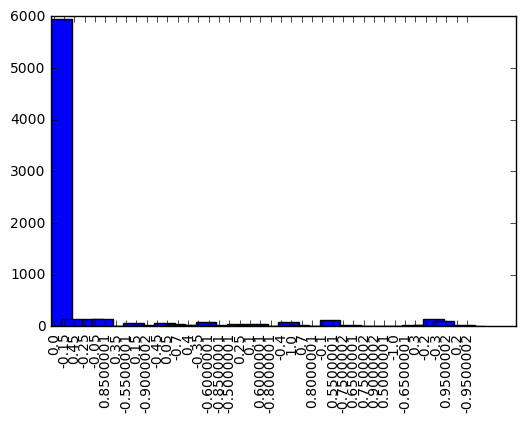

most common steering angles: [('-0.05', 146), ('0', 146), ('-0.15', 142), ('-0.2', 140), ('-0.25', 130), ('-0.1', 123), ('-0.3', 100), ('-0.4', 89), ('-0.35', 87), ('-0.45', 57)]


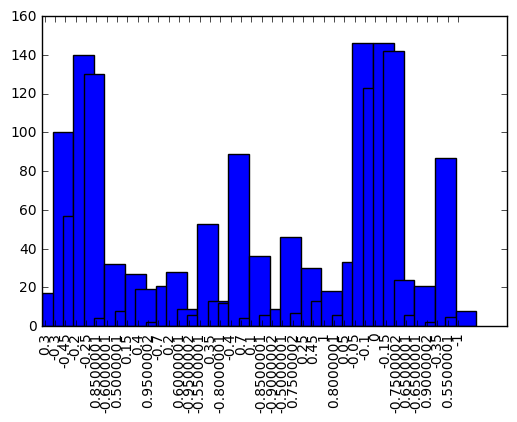

In [51]:
'''
CSV file format
center,left,right,steering,throttle,brake,speed
IMG/center_2016_12_01_13_30_48_287.jpg, IMG/left_2016_12_01_13_30_48_287.jpg, IMG/right_2016_12_01_13_30_48_287.jpg, 0, 0, 0, 22.14829
IMG/center_2016_12_01_13_30_48_404.jpg, IMG/left_2016_12_01_13_30_48_404.jpg, IMG/right_2016_12_01_13_30_48_404.jpg, 0, 0, 0, 21.87963
'''

def data_preprocessing(csv_path):
    sample_line_list = []
    counter = Counter()
    with open(csv_path) as csvfile:
        next(csvfile, None) ## skip the header
        reader = csv.reader(csvfile)
        for line in reader:
            sample_line_list.append(line)
            counter[float(line[3])] += 1    

    keys = counter.keys()
    #print(keys)
    
    most_common_angles = counter.most_common(10)
    print("most common steering angles:",most_common_angles)
    indexes = np.arange(len(keys)) 
    angle_count = [counter[k] for k in keys]
    
    plt.bar(indexes, angle_count, width=2)
    plt.xticks(indexes + 0.5 * 0.5, keys, rotation=90)
    plt.show()
    
    
    counter2 = Counter()
    final_sample_list = []
    for sample in sample_line_list:
        if abs(float(sample[3]) - 0.00) < 0.001: #angle = 0.0
            if random.random() <= most_common_angles[1][1]/most_common_angles[0][1]:
                final_sample_list.append(sample)
                counter2[sample[3]] += 1
        else:
            final_sample_list.append(sample)
            counter2[sample[3]] += 1
    
    
    print("most common steering angles:", counter2.most_common(10))
    keys2 = counter2.keys()
    indexes2 = np.arange(len(keys2)) 
    angle_count2 = [counter2[k] for k in keys2]
    
    plt.bar(indexes2, angle_count2, width=2)
    plt.xticks(indexes + 0.5 * 0.5, keys2, rotation=90)
    plt.show()
    
    return final_sample_list
    

    
data_dict = data_preprocessing(CSV_PATH)

most common steering angles: [(0.0, 5942), (-0.05, 146), (-0.15, 142), (-0.2, 140), (-0.25, 130), (-0.1, 123), (-0.3, 100), (-0.4, 89), (-0.35, 87), (-0.45, 57)]


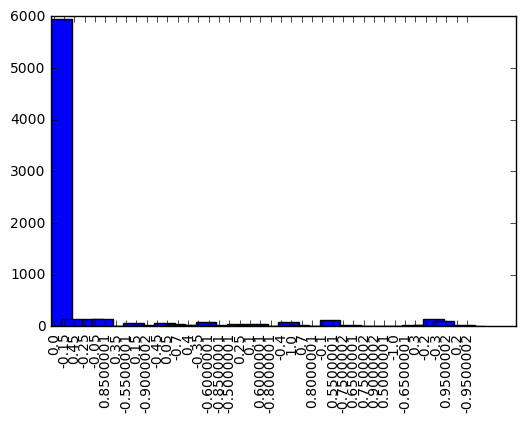

most common steering angles: [('-0.05', 146), ('-0.15', 142), ('-0.2', 140), ('0', 133), ('-0.25', 130), ('-0.1', 123), ('-0.3', 100), ('-0.4', 89), ('-0.35', 87), ('-0.45', 57)]


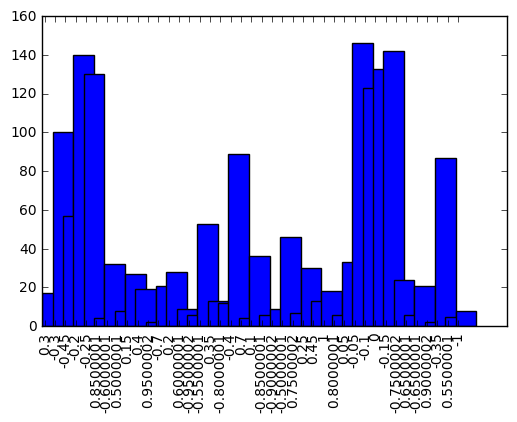

[array([[[[ 40,  33,  14],
         [ 44,  37,  18],
         [ 49,  42,  23],
         ..., 
         [194, 152, 123],
         [195, 153, 124],
         [195, 153, 124]],

        [[ 45,  38,  19],
         [ 48,  41,  22],
         [ 49,  42,  23],
         ..., 
         [195, 153, 124],
         [195, 153, 124],
         [195, 153, 124]],

        [[ 51,  44,  25],
         [ 51,  44,  25],
         [ 49,  42,  23],
         ..., 
         [196, 154, 125],
         [196, 154, 125],
         [196, 154, 125]],

        ..., 
        [[ 90, 108, 107],
         [ 93, 111, 110],
         [104, 122, 121],
         ..., 
         [ 91, 105, 104],
         [ 91, 105, 104],
         [ 89, 103, 102]],

        [[100, 118, 117],
         [115, 133, 132],
         [123, 141, 140],
         ..., 
         [120, 134, 133],
         [103, 117, 116],
         [ 89, 103, 102]],

        [[102, 120, 119],
         [103, 121, 120],
         [ 93, 111, 110],
         ..., 
         [153, 167, 166],
 

In [52]:
def generator(samples, batch_size=1000):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0].split('/')[-1]
                
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])        

                
                images.append(center_image)
                angles.append(center_angle)
                
                #flipping images And steering to avoid bias 
                flipped_center_image = np.fliplr(center_image)
                flipped_center_angle = -center_angle
                
                images.append(flipped_center_image)
                angles.append(flipped_center_angle)
                
                '''
                if center_angle != 0:
                    fig, ax = plt.subplots(nrows=2,ncols=1)
                    ax[0].imshow(center_image)
                    ax[0].set_title(str(center_angle))                
                    
                    ax[1].imshow(flipped_center_image)
                    ax[1].set_title(str(flipped_center_angle))
                    
                    plt.show()
                '''
                
            X_train = np.array(images)
            y_train = np.array(angles)

            yield shuffle(X_train, y_train)

            
print(next(generator(data_preprocessing(CSV_PATH))))        

In [53]:


image_color_channel = 3
image_height = 160
image_width = 320


def model_setup():
    
    model = Sequential()

    #cropping layer
    crop_top = 50
    crop_bottom = 20
    crop_left = 2
    crop_right = 2
    #model.add(Cropping2D(cropping=((crop_top,crop_bottom), (crop_left,crop_right)), input_shape=(160,320,3),  dim_ordering='tf'))
    
    #lambda layer: to normalize images to [-0.5, +0.5] 
    #model.add(Lambda(lambda x: (x / 255.0) - 0.5))
    
    
    #conv layer
    n_filters = 32
    model.add(Convolution2D(n_filters, 3, 3, border_mode = "valid"))
    
    #pooling 
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #drop out
    model.add(Dropout(0.5))
    
    #relu
    model.add(Activation("relu"))
    
    #conv layer
    model.add(Convolution2D(32, 5, 5, border_mode = "valid"))
    
    #pooling 
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #drop out
    model.add(Dropout(0.5))
    
    #relu
    model.add(Activation("relu"))
    
    
    #conv layer
    model.add(Convolution2D(32, 5, 5, border_mode = "valid"))
    
    #pooling 
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #drop out
    model.add(Dropout(0.5))
    
    #relu
    model.add(Activation("relu")) 
    
    #conv layer
    model.add(Convolution2D(32, 5, 5, border_mode = "valid"))
    
    #pooling 
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #drop out
    model.add(Dropout(0.5))
    
    #relu
    model.add(Activation("relu")) 
    
    # flatten()
    model.add(Flatten())
    
    
    model.add(Dense(512))
    model.add(Dense(128))
    model.add(Dense(32))
    model.add(Dense(8))
    #output
    model.add(Dense(1))
    
    return model



most common steering angles: [(0.0, 5942), (-0.05, 146), (-0.15, 142), (-0.2, 140), (-0.25, 130), (-0.1, 123), (-0.3, 100), (-0.4, 89), (-0.35, 87), (-0.45, 57)]


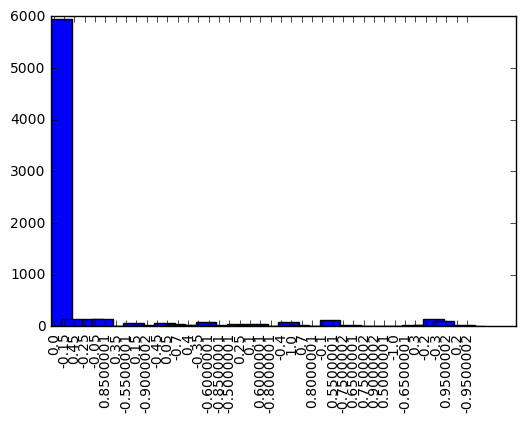

most common steering angles: [('-0.05', 146), ('-0.15', 142), ('0', 141), ('-0.2', 140), ('-0.25', 130), ('-0.1', 123), ('-0.3', 100), ('-0.4', 89), ('-0.35', 87), ('-0.45', 57)]


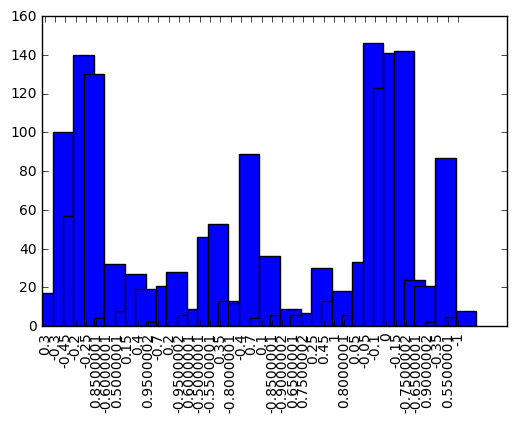

total sample count: 1680
train sample count:  1075 
validation sample count:  269 
test sample count:  336
sample data example ['C:\\Localdata\\data\\behavioralclone\\train_data_3\\IMG\\center_2017_02_27_13_39_43_576.jpg', 'C:\\Localdata\\data\\behavioralclone\\train_data_3\\IMG\\left_2017_02_27_13_39_43_576.jpg', 'C:\\Localdata\\data\\behavioralclone\\train_data_3\\IMG\\right_2017_02_27_13_39_43_576.jpg', '-0.5000001', '0', '0', '19.68314']


ValueError: The first layer in a Sequential model must get an `input_shape` or `batch_input_shape` argument.

In [54]:
def flow_setup():
    
    samples = data_preprocessing(CSV_PATH)
    print("total sample count:", len(samples))
    train_validation_samples, test_samples = train_test_split(samples, test_size = 0.2, random_state = 42)
    train_samples, validation_samples = train_test_split(train_validation_samples, test_size = 0.2, random_state = 42)
    print("train sample count: ", len(train_samples), "\nvalidation sample count: ", len(validation_samples), "\ntest sample count: ", len(test_samples))
    print("sample data example", train_samples[random.randint(0, len(train_samples))])
    
    train_generator = generator(train_samples, batch_size = 32)
    validation_generator = generator(validation_samples, batch_size = 32)
    test_generator = generator(test_samples, batch_size = 32)            
    #print("generator output example: \n", next(train_generator))
    
    model = model_setup()
    model.compile(loss = "mse", optimizer="adam")
    print(model.summary())
    
    history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=5, verbose=1)
    score = model.evaluate_generator(test_generator, 1500, max_q_size=10, nb_worker=1, pickle_safe=False)
    print(score)
    
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()
    
    
    model.save('model.h5')
    print("job finished. model saved")
    
flow_setup()